In [112]:
from sklearn.cluster import KMeans
from numpy import array
import tensorflow as tf
import matplotlib.pyplot as plt
from numpy import hstack
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.cm as cm
from __future__ import print_function
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import Birch
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import Birch
from keras.wrappers.scikit_learn import KerasRegressor


In [2]:
!pip install dython

# EDA

In [8]:
df = pd.read_csv('CensusCanada2016Training.csv')
df.head()

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter
0,4051,1441,68242.12,1441,323,199,53,182,526,911,525,5,1343,919,424
1,2329,1026,88172.37,1026,927,70,15,3,0,792,230,4,991,778,213
2,5276,2071,103853.38,2071,3,607,567,651,106,1418,652,1,1903,1522,381
3,5967,2203,82796.63,2203,133,1695,248,79,0,1397,806,0,2079,1272,807
4,4236,1419,91648.22,1419,0,7,127,938,143,914,505,0,1348,1186,162


In [9]:
df.describe()

,Total Population,Total Households,Median Household Income (Current Year $),Total Households For Period Of Construction,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Total Households for Tenure,Dwellings by Tenure Owner,Dwellings by Tenure Renter
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,4866.967400,1927.776200,77241.071536,1927.776200,386.510600,555.437800,260.48240,237.92820,138.595600,1134.79180,777.188400,15.796000,1810.954800,1182.21140,628.155800
std,2491.841571,974.811432,33371.567357,974.811432,416.908471,448.327845,257.86717,265.43332,221.809214,812.09222,891.021549,62.949187,897.938845,710.51703,594.295093
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,3289.750000,1333.750000,53040.835000,1333.750000,47.000000,192.000000,74.00000,58.00000,17.000000,534.00000,146.000000,0.000000,1258.000000,687.00000,201.000000
50%,4655.000000,1825.000000,76206.780000,1825.000000,238.000000,470.000000,181.00000,143.00000,52.000000,1076.00000,487.000000,2.000000,1724.500000,1112.00000,456.000000
75%,6233.750000,2428.250000,95438.495000,2428.250000,613.000000,830.000000,369.00000,325.00000,157.000000,1592.00000,1119.000000,6.000000,2281.250000,1570.00000,879.000000
max,30789.000000,15388.000000,669559.560000,15388.000000,2411.000000,3547.000000,1740.00000,2360.00000,2262.000000,9123.00000,15248.000000,1378.000000,11891.000000,8628.00000,6813.000000


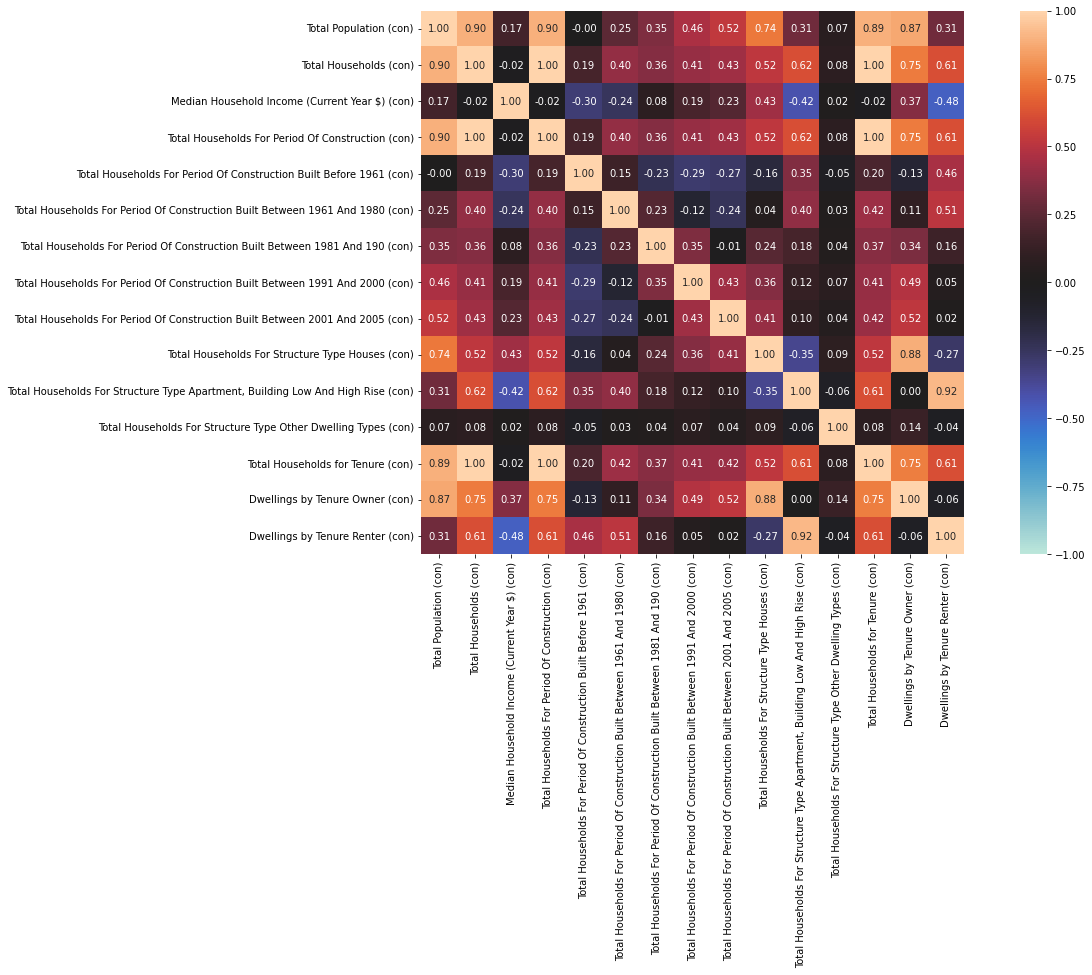

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f047f2aa7d0>,
 'corr':                                                     Total Population (con)  ...  Dwellings by Tenure Renter (con)
 Total Population (con)                                            1.000000  ...                          0.309932
 Total Households (con)                                            0.898437  ...                          0.612867
 Median Household Income (Current Year $) (con)                    0.173635  ...                         -0.476204
 Total Households For Period Of Construction (con)                 0.898437  ...                          0.612867
 Total Households For Period Of Construction Bui...               -0.004929  ...                          0.458470
 Total Households For Period Of Construction Bui...                0.251922  ...                          0.510058
 Total Households For Period Of Construction Bui...                0.350548  ...                          0.155922
 Total

In [10]:
# correlation graph
from dython import nominal
nominal.associations(df,figsize=(20,10),mark_columns=True)

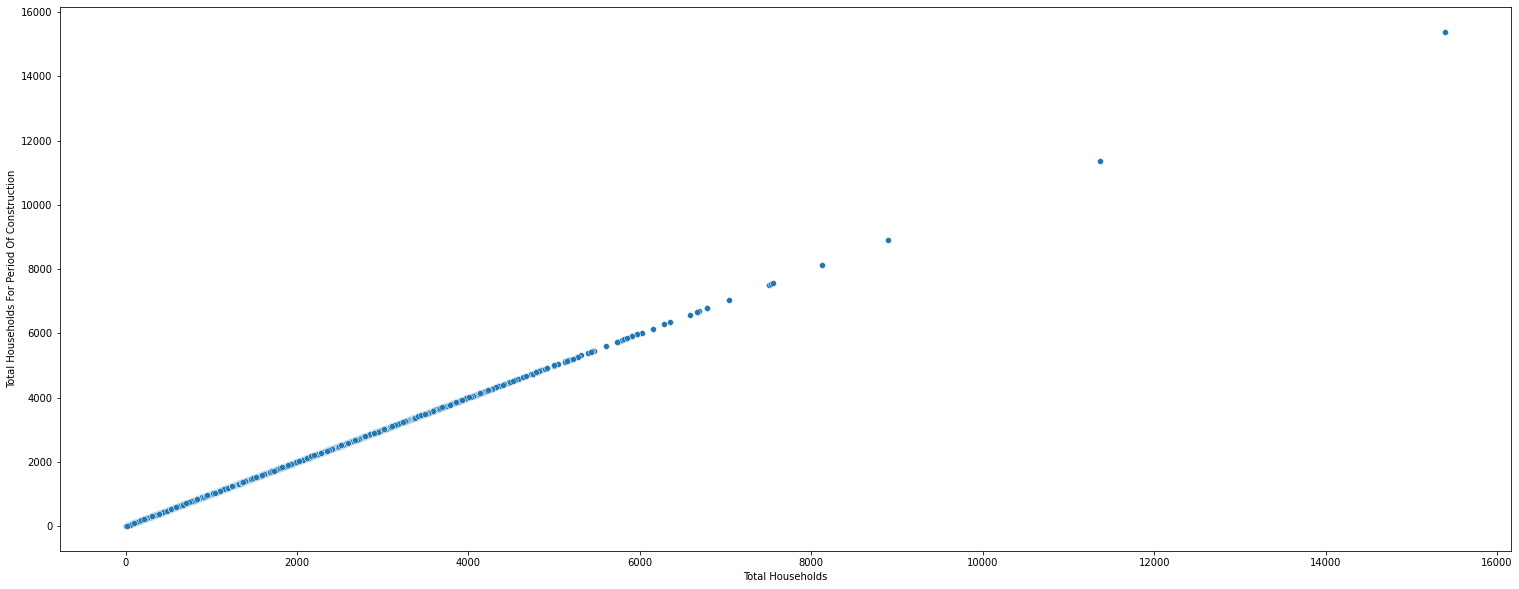

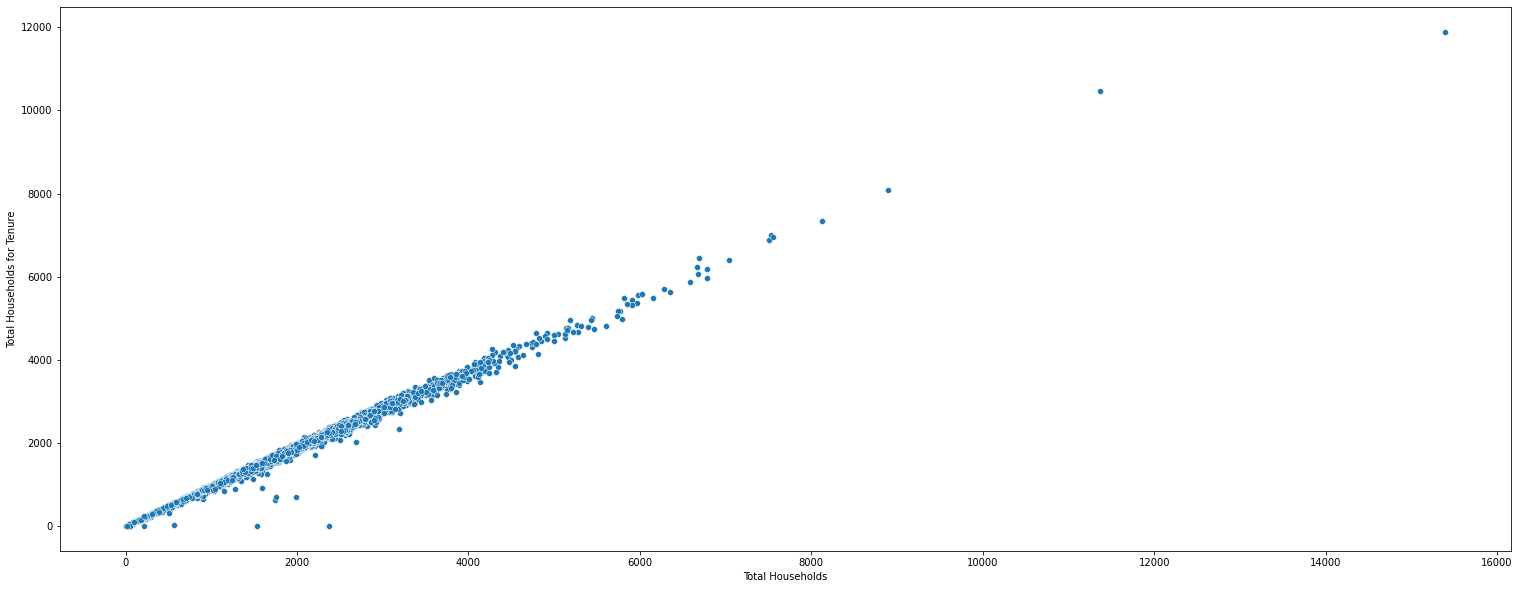

In [11]:
# scatter plot to show correlation
plt.figure(figsize=(26, 10))
sns.scatterplot(x = df.columns[1], data = df, y = df.columns[3])
plt.figure(figsize=(26, 10))
sns.scatterplot(x = df.columns[1], data = df, y = df.columns[-3])

In [12]:
df['Total Households Not for Tenure']=df['Total Households']-df['Total Households for Tenure']
df['Average Household Size'] = np.where(df['Total Households for Tenure'] == 0, 0, df['Total Population']/df['Total Households for Tenure'])

In [13]:
df = df.drop(columns=['Total Households For Period Of Construction'])

In [14]:
df = df.drop(columns=['Total Households for Tenure'])

In [15]:
#Shift Median Income to the end
df = df[[c for c in df if c not in ['Median Household Income (Current Year $)']] + ['Median Household Income (Current Year $)']]

In [16]:
df

,Total Population,Total Households,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Total Households Not for Tenure,Average Household Size,Median Household Income (Current Year $)
0,4051,1441,323,199,53,182,526,911,525,5,919,424,98,3.016381,68242.12
1,2329,1026,927,70,15,3,0,792,230,4,778,213,35,2.350151,88172.37
2,5276,2071,3,607,567,651,106,1418,652,1,1522,381,168,2.772465,103853.38
3,5967,2203,133,1695,248,79,0,1397,806,0,1272,807,124,2.870130,82796.63
4,4236,1419,0,7,127,938,143,914,505,0,1186,162,71,3.142433,91648.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2588,953,0,3,31,501,276,926,27,0,847,28,78,2.957714,108823.38
4996,9036,3859,678,986,386,359,448,2388,1436,35,2602,1047,210,2.476295,68735.64
4997,4689,1895,164,485,511,523,29,677,1038,180,1219,545,131,2.658163,71370.58
4998,3673,1038,544,185,40,95,13,796,242,0,546,347,145,4.113102,58258.26


In [ ]:
# this is not used?
'''
X1 = df.drop(columns=['Median Household Income (Current Year $)']).values
scaler = StandardScaler()
X_scaled1 = scaler.fit_transform(X1)
'''

In [17]:
# assign Median Income as predictor
X  = df.iloc[:,0:-1]
y = pd.DataFrame(df.iloc[:,-1])
y_fit = StandardScaler().fit(y)
X_fit = StandardScaler().fit(X)

In [18]:
# Standardize the data
y_scaled = pd.DataFrame(y_fit.transform(y))
y_scaled.columns = y.columns
X_scaled = pd.DataFrame(X_fit.transform(X))
X_scaled.columns = X.columns
data = pd.concat([X_scaled,y_scaled],axis =1)
data

,Total Population,Total Households,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Total Households Not for Tenure,Average Household Size,Median Household Income (Current Year $)
0,-0.327488,-0.499404,-0.152352,-0.795118,-0.804690,-0.210726,1.746741,-0.275602,-0.283061,-0.171521,-0.370488,-0.343560,-0.162176,0.130411,-0.269686
1,-1.018613,-0.925170,1.296552,-1.082882,-0.952068,-0.885163,-0.624904,-0.422152,-0.614175,-0.187408,-0.568954,-0.698638,-0.705019,-0.200720,0.327596
2,0.164165,0.146939,-0.919984,0.115022,1.188784,1.556372,-0.146968,0.348774,-0.140514,-0.235070,0.478275,-0.415922,0.440983,0.009179,0.797534
3,0.441498,0.282364,-0.608133,2.542060,-0.048411,-0.598810,-0.624904,0.322912,0.032339,-0.250958,0.126383,0.300965,0.061855,0.057721,0.166492
4,-0.253239,-0.521975,-0.927180,-1.223419,-0.517692,2.637731,0.019859,-0.271907,-0.305510,-0.250958,0.005333,-0.784463,-0.394823,0.193062,0.431762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.914663,-1.000064,-0.927180,-1.232342,-0.890014,0.991202,0.619533,-0.257129,-0.842026,-0.250958,-0.471832,-1.009963,-0.334507,0.101252,0.946478
4996,1.673240,1.981324,0.699239,0.960470,0.486802,0.456174,1.395052,1.543339,0.739463,0.305102,1.998447,0.704845,0.802879,-0.138024,-0.254896
4997,-0.071427,-0.033626,-0.533769,-0.157128,0.971596,1.074094,-0.494148,-0.563775,0.292740,2.608778,0.051782,-0.139937,0.122171,-0.047631,-0.175931
4998,-0.479199,-0.912859,0.377793,-0.826348,-0.855109,-0.538525,-0.566289,-0.417226,-0.600706,-0.250958,-0.895510,-0.473139,0.242803,0.675506,-0.568889


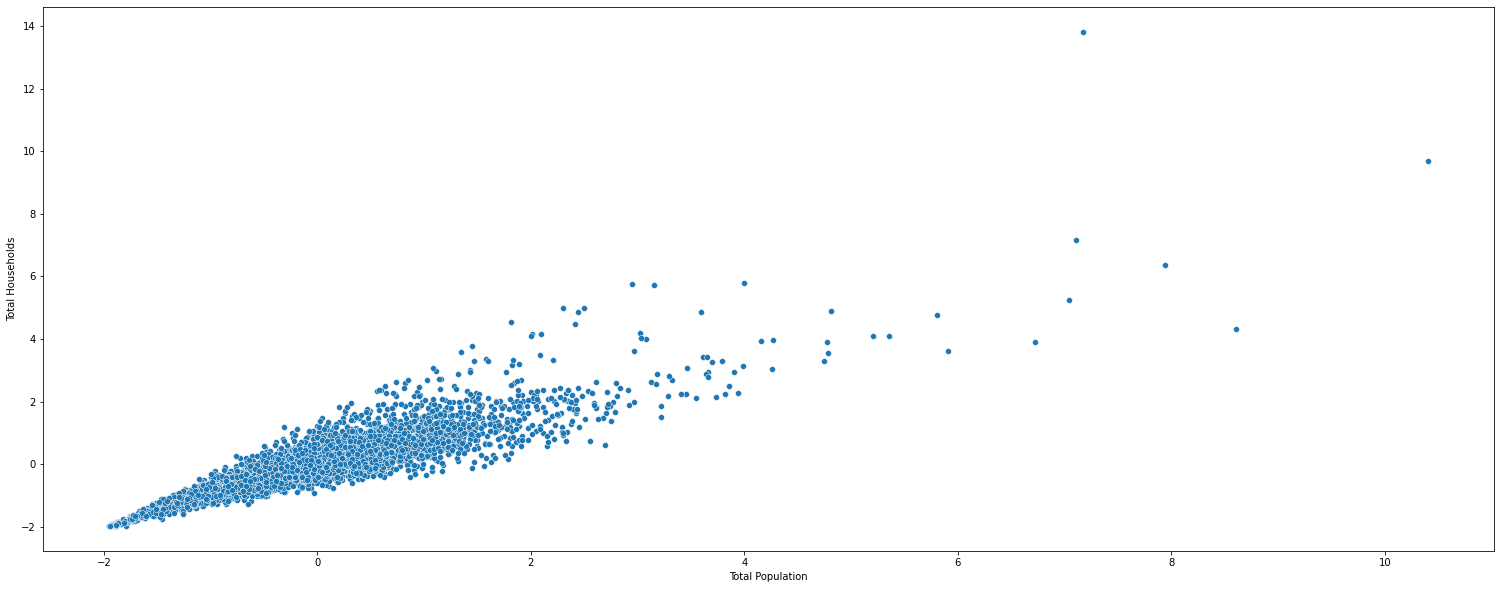

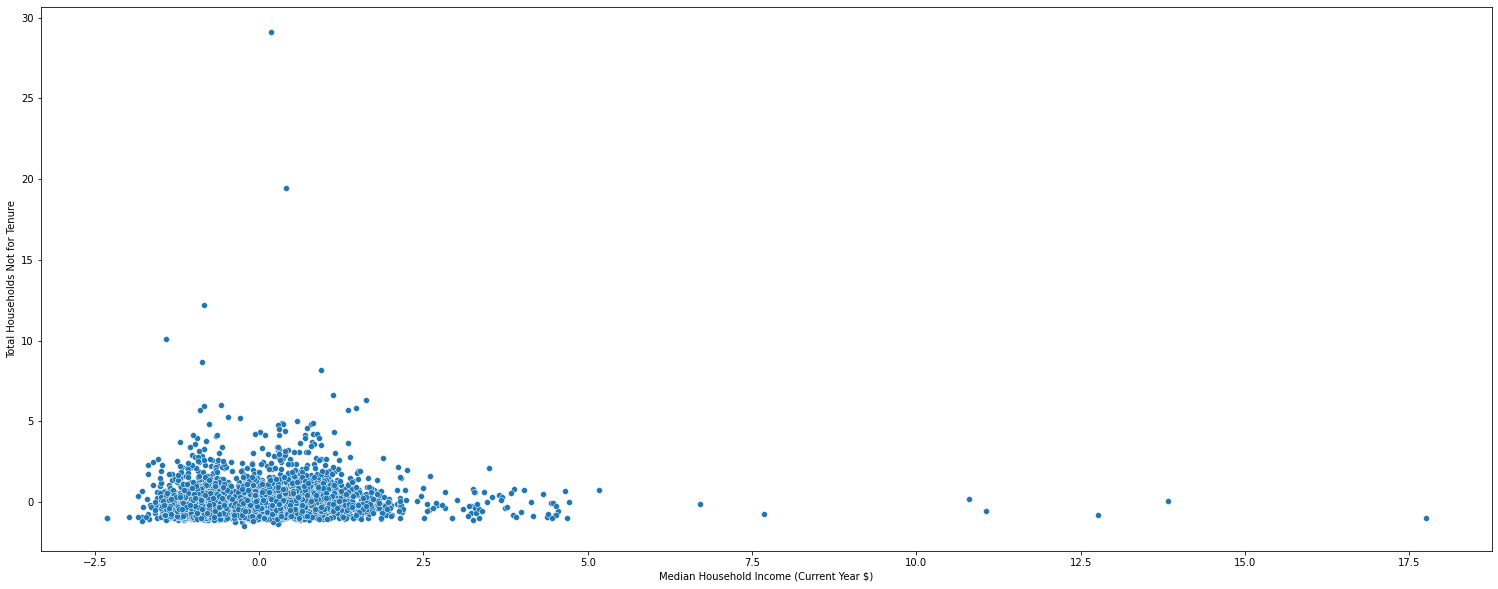

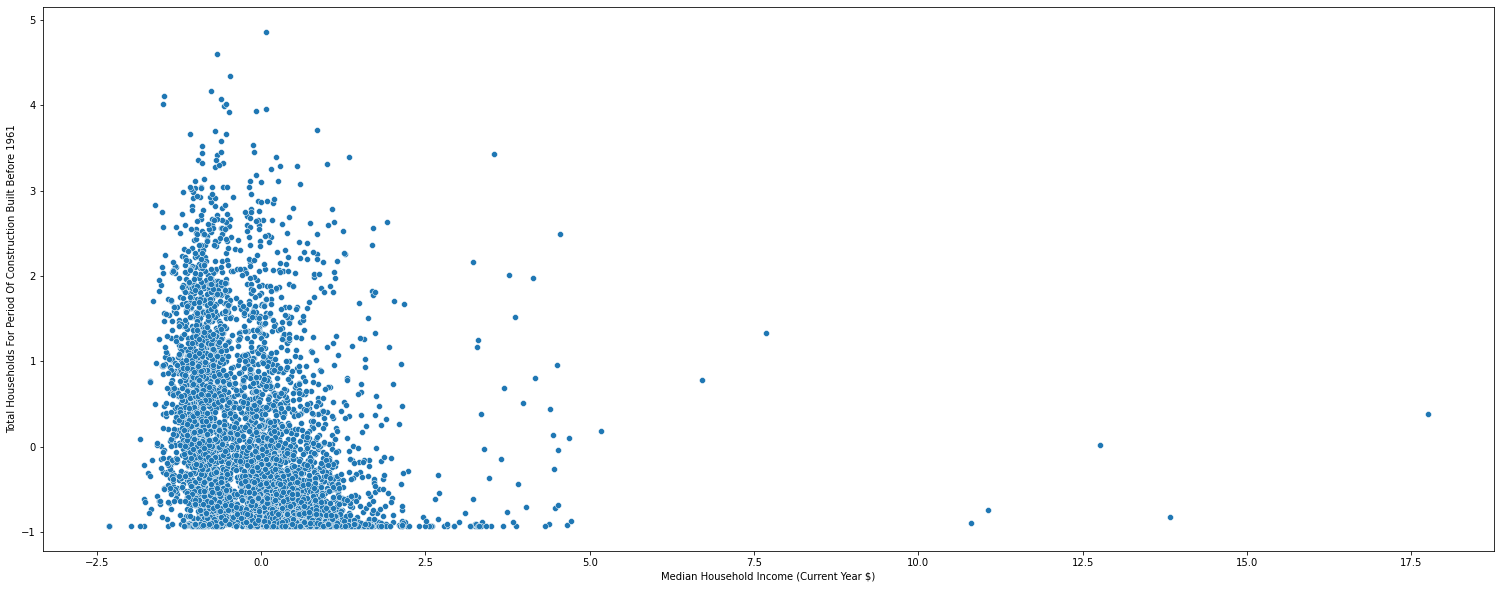

In [19]:
# scatter plot to show interesting findings

plt.figure(figsize=(26, 10))
sns.scatterplot(x = data.columns[0], data = data, y = data.columns[1])
plt.figure(figsize=(26, 10))
sns.scatterplot(x = data.columns[-1], data = data, y = data.columns[-3])
plt.figure(figsize=(26, 10))
sns.scatterplot(x = data.columns[-1], data = data, y = data.columns[2])

# Clustering

## Optimal K for K-means

In [20]:
ks = range(1, 10)
inertias = []

In [21]:
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

([<matplotlib.axis.XTick at 0x7f047c3c0710>,
 <a list of 9 Text major ticklabel objects>)

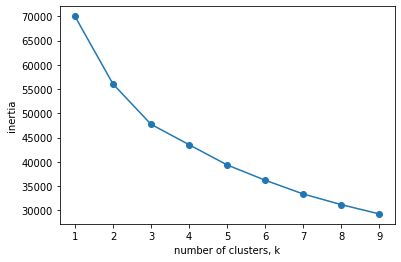

In [22]:
plt.plot(ks, inertias, '-o')
#plt.scatter(ks[2], inertias[2], marker="X", s=300, c="r")
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)

In [23]:
#Finding the optimal number of clusters for k-means using cross validation
#initialize for loop to calculate silhouette_score for each #cluster
k_values = np.array([2,3,4,5,6,7,9,10])
silhouette_score_values=list()
for i in k_values:
    classifier=KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True)
    classifier.fit(X_scaled)
    labels= classifier.predict(X_scaled)
    print ('Number Of Clusters: '+ str(i))
 #   print (i)
    print ('Silhouette score value '+str(silhouette_score(X_scaled,labels ,metric='euclidean', sample_size=None, random_state=None)))
    silhouette_score_values.append(silhouette_score(X_scaled,labels,metric='euclidean', sample_size=None, random_state=None))

Number Of Clusters: 2
Silhouette score value 0.25848433515752783
Number Of Clusters: 3
Silhouette score value 0.2589593856643726
Number Of Clusters: 4
Silhouette score value 0.2610580379367645
Number Of Clusters: 5
Silhouette score value 0.2130866494322207
Number Of Clusters: 6
Silhouette score value 0.18699498809804863
Number Of Clusters: 7
Silhouette score value 0.19172398151767453
Number Of Clusters: 9
Silhouette score value 0.19027865619259532
Number Of Clusters: 10
Silhouette score value 0.19599136301072853


In [24]:
best_k=k_values[silhouette_score_values.index(max(silhouette_score_values))]
print ('Optimal number of clusters is:',best_k)

Optimal number of clusters is: 4


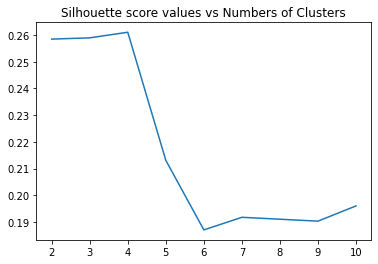

In [25]:
plt.plot(k_values, silhouette_score_values)
plt.title('Silhouette score values vs Numbers of Clusters')
plt.show()

## K-means and Interpretation

In [26]:
KMeansmodel = KMeans(n_clusters = 3)
KMeansmodel.fit(X_scaled)
KMeansmodel.cluster_centers_

array([[ 0.93388748,  0.61864703, -0.55746172, -0.24793342,  0.5507541 ,
         0.91362644,  0.85576091,  1.1201797 , -0.36085754,  0.23680732,
         1.10244196, -0.38961947,  0.446828  ,  0.19513031],
       [ 0.48010471,  0.92853003,  0.79550324,  0.98354947,  0.28865449,
         0.03334389, -0.0812008 , -0.48619799,  1.46727295, -0.11743645,
        -0.09807306,  1.53189444,  0.56012765, -0.2101982 ],
       [-0.63354735, -0.6341725 , -0.00199135, -0.22213521, -0.37556834,
        -0.4665007 , -0.39745319, -0.38678764, -0.33587095, -0.07661909,
        -0.51431859, -0.34425736, -0.41921293, -0.02328295]])

In [27]:
cluster_center = pd.DataFrame(data=KMeansmodel.cluster_centers_, index=["cluster1", "cluster2", "cluster3"], columns=df.drop(columns=['Median Household Income (Current Year $)']).columns)
cluster_center

,Total Population,Total Households,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Total Households Not for Tenure,Average Household Size
cluster1,0.933887,0.618647,-0.557462,-0.247933,0.550754,0.913626,0.855761,1.120180,-0.360858,0.236807,1.102442,-0.389619,0.446828,0.195130
cluster2,0.480105,0.928530,0.795503,0.983549,0.288654,0.033344,-0.081201,-0.486198,1.467273,-0.117436,-0.098073,1.531894,0.560128,-0.210198
cluster3,-0.633547,-0.634172,-0.001991,-0.222135,-0.375568,-0.466501,-0.397453,-0.386788,-0.335871,-0.076619,-0.514319,-0.344257,-0.419213,-0.023283


Cluster1 (Rich): Newly built households, house structure type, dwellings by tenure owner, average household size is above average.
Cluster2 (Poor): Old buildings, apartment, building low and high rise structure type, dwellings by tenure renter, average household size is low. Cluster3 (Median): everything is kind of in between

In [28]:
arr_k = KMeansmodel.predict(X_scaled).reshape(-1,1)
arr=arr_k
col_name = df.columns.tolist().copy()
col_name.append('Cluster')
col_name

['Total Population',
 'Total Households',
 'Total Households For Period Of Construction Built Before 1961',
 'Total Households For Period Of Construction Built Between 1961 And 1980',
 'Total Households For Period Of Construction Built Between 1981 And 190',
 'Total Households For Period Of Construction Built Between 1991 And 2000',
 'Total Households For Period Of Construction Built Between 2001 And 2005',
 'Total Households For Structure Type Houses',
 'Total Households For Structure Type Apartment, Building Low And High Rise',
 'Total Households For Structure Type Other Dwelling Types',
 'Dwellings by Tenure Owner',
 'Dwellings by Tenure Renter',
 'Total Households Not for Tenure',
 'Average Household Size',
 'Median Household Income (Current Year $)',
 'Cluster']

In [29]:
stacked = np.hstack((df.values,arr))
df_kmeans = pd.DataFrame(data=stacked, columns=col_name)
df_kmeans

,Total Population,Total Households,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Total Households Not for Tenure,Average Household Size,Median Household Income (Current Year $),Cluster
0,4051.0,1441.0,323.0,199.0,53.0,182.0,526.0,911.0,525.0,5.0,919.0,424.0,98.0,3.016381,68242.12,2.0
1,2329.0,1026.0,927.0,70.0,15.0,3.0,0.0,792.0,230.0,4.0,778.0,213.0,35.0,2.350151,88172.37,2.0
2,5276.0,2071.0,3.0,607.0,567.0,651.0,106.0,1418.0,652.0,1.0,1522.0,381.0,168.0,2.772465,103853.38,0.0
3,5967.0,2203.0,133.0,1695.0,248.0,79.0,0.0,1397.0,806.0,0.0,1272.0,807.0,124.0,2.870130,82796.63,1.0
4,4236.0,1419.0,0.0,7.0,127.0,938.0,143.0,914.0,505.0,0.0,1186.0,162.0,71.0,3.142433,91648.22,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2588.0,953.0,0.0,3.0,31.0,501.0,276.0,926.0,27.0,0.0,847.0,28.0,78.0,2.957714,108823.38,2.0
4996,9036.0,3859.0,678.0,986.0,386.0,359.0,448.0,2388.0,1436.0,35.0,2602.0,1047.0,210.0,2.476295,68735.64,0.0
4997,4689.0,1895.0,164.0,485.0,511.0,523.0,29.0,677.0,1038.0,180.0,1219.0,545.0,131.0,2.658163,71370.58,2.0
4998,3673.0,1038.0,544.0,185.0,40.0,95.0,13.0,796.0,242.0,0.0,546.0,347.0,145.0,4.113102,58258.26,2.0


In [30]:
df_kmeans['Cluster'].value_counts()

2.0    2705
0.0    1346
1.0     949
Name: Cluster, dtype: int64

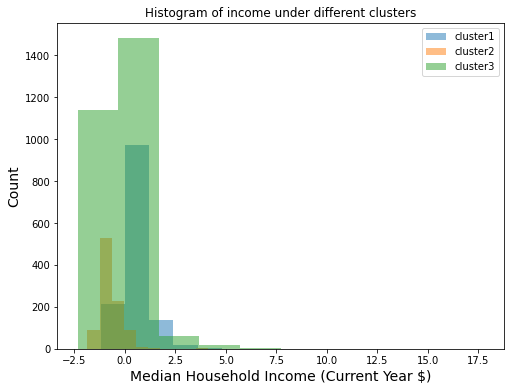

In [31]:
# visual income
df_viz = df_kmeans.copy()
income = df_viz[['Median Household Income (Current Year $)']].values
income = preprocessing.scale(income)
df_viz['Median Household Income (Current Year $)'] = income

plt.figure(figsize=(8,6))
plt.hist(df_viz[df_viz['Cluster']==0]['Median Household Income (Current Year $)'], alpha=0.5, label="cluster1")
plt.hist(df_viz[df_viz['Cluster']==1]['Median Household Income (Current Year $)'], alpha=0.5, label="cluster2")
plt.hist(df_viz[df_viz['Cluster']==2]['Median Household Income (Current Year $)'], alpha=0.5, label="cluster3")
plt.xlabel("Median Household Income (Current Year $)", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of income under different clusters")
plt.legend(loc='upper right')

In [32]:
c1 = df_kmeans[df_kmeans['Cluster']==0]
c1['Median Household Income (Current Year $)'].describe()

count      1346.000000
mean      97256.649792
std       23893.511703
min       37999.600000
25%       82935.185000
50%       95453.680000
75%      108444.032500
max      437853.930000
Name: Median Household Income (Current Year $), dtype: float64

In [33]:
c2 = df_kmeans[df_kmeans['Cluster']==1]
c2['Median Household Income (Current Year $)'].describe()

count       949.000000
mean      54063.453351
std       17651.597874
min       16000.930000
25%       42990.160000
50%       50634.310000
75%       60583.310000
max      215418.630000
Name: Median Household Income (Current Year $), dtype: float64

In [34]:
c3 = df_kmeans[df_kmeans['Cluster']==2]
c3['Median Household Income (Current Year $)'].describe()

count      2705.000000
mean      75412.824336
std       35698.190066
min           0.000000
25%       52553.940000
50%       73002.840000
75%       91074.820000
max      669559.560000
Name: Median Household Income (Current Year $), dtype: float64

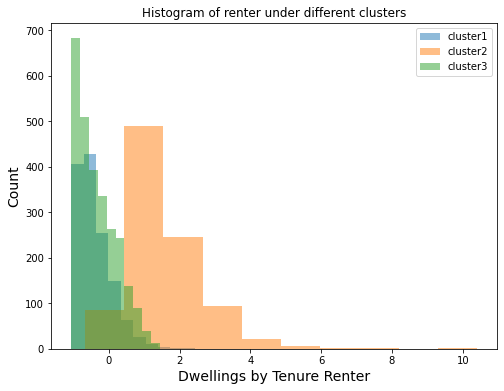

In [35]:
#visual Renter
df_viz = df_kmeans.copy()
renter = df_viz[['Dwellings by Tenure Renter']].values
renter = preprocessing.scale(renter)
df_viz['Dwellings by Tenure Renter'] = renter

plt.figure(figsize=(8,6))
plt.hist(df_viz[df_viz['Cluster']==0]['Dwellings by Tenure Renter'], alpha=0.5, label="cluster1")
plt.hist(df_viz[df_viz['Cluster']==1]['Dwellings by Tenure Renter'], alpha=0.5, label="cluster2")
plt.hist(df_viz[df_viz['Cluster']==2]['Dwellings by Tenure Renter'], alpha=0.5, label="cluster3")
plt.xlabel("Dwellings by Tenure Renter", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of renter under different clusters")
plt.legend(loc='upper right')

In [36]:
c1 = df_kmeans[df_kmeans['Cluster']==0]
c1['Dwellings by Tenure Renter'].describe()

count    1346.000000
mean      396.630015
std       282.366054
min         0.000000
25%       185.000000
50%       327.000000
75%       546.000000
max      2075.000000
Name: Dwellings by Tenure Renter, dtype: float64

In [37]:
c2 = df_kmeans[df_kmeans['Cluster']==1]
c2['Dwellings by Tenure Renter'].describe()

count     949.000000
mean     1538.793467
std       647.313934
min       227.000000
25%      1125.000000
50%      1406.000000
75%      1819.000000
max      6813.000000
Name: Dwellings by Tenure Renter, dtype: float64

In [38]:
c3 = df_kmeans[df_kmeans['Cluster']==2]
c3['Dwellings by Tenure Renter'].describe()

count    2705.000000
mean      423.881701
std       326.992100
min         0.000000
25%       147.000000
50%       355.000000
75%       656.000000
max      1485.000000
Name: Dwellings by Tenure Renter, dtype: float64

Text(0, 0.5, 'Median Household Income (Current Year $)')

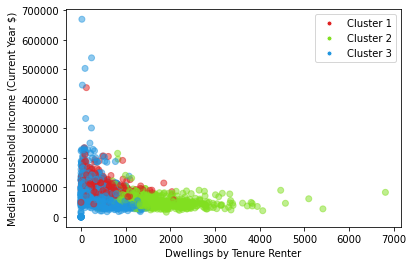

In [39]:
# cluster visual
from matplotlib.lines import Line2D
# create color
df_viz = df_kmeans.copy()

colors = ['#DF2020', '#81DF20', '#2095DF']
df_viz['c'] = df_viz.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
# visual Total Households For Structure Type Houses
plt.scatter(df_kmeans['Dwellings by Tenure Renter'],df_kmeans['Median Household Income (Current Year $)'],c=df_viz.c,alpha=0.5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Dwellings by Tenure Renter')
plt.ylabel('Median Household Income (Current Year $)')

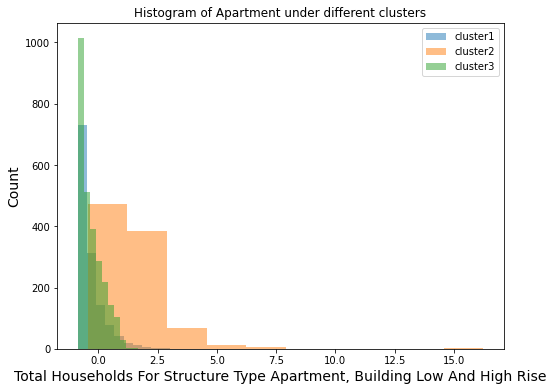

In [40]:
#visual Apartment
df_viz = df_kmeans.copy()
apartment = df_viz[['Total Households For Structure Type Apartment, Building Low And High Rise']].values
apartment = preprocessing.scale(apartment)
df_viz['Total Households For Structure Type Apartment, Building Low And High Rise'] = apartment

plt.figure(figsize=(8,6))
plt.hist(df_viz[df_viz['Cluster']==0]['Total Households For Structure Type Apartment, Building Low And High Rise'], alpha=0.5, label="cluster1")
plt.hist(df_viz[df_viz['Cluster']==1]['Total Households For Structure Type Apartment, Building Low And High Rise'], alpha=0.5, label="cluster2")
plt.hist(df_viz[df_viz['Cluster']==2]['Total Households For Structure Type Apartment, Building Low And High Rise'], alpha=0.5, label="cluster3")
plt.xlabel("Total Households For Structure Type Apartment, Building Low And High Rise", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of Apartment under different clusters")
plt.legend(loc='upper right')

Text(0, 0.5, 'Median Household Income (Current Year $)')

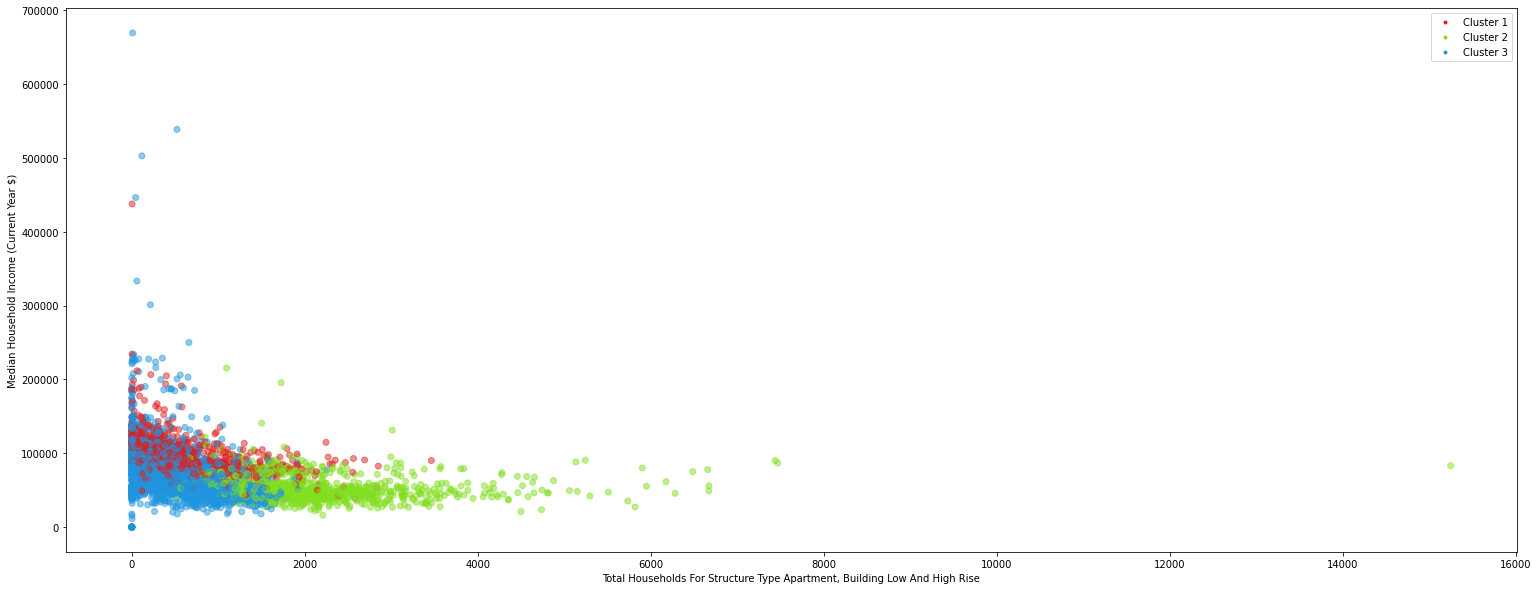

In [41]:
# cluster visual
from matplotlib.lines import Line2D
plt.figure(figsize=(26, 10))
# create color
df_viz = df_kmeans.copy()

colors = ['#DF2020', '#81DF20', '#2095DF']
df_viz['c'] = df_viz.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
# visual Total Households For Structure Type Houses
plt.scatter(df_kmeans['Total Households For Structure Type Apartment, Building Low And High Rise'],df_kmeans['Median Household Income (Current Year $)'],c=df_viz.c,alpha=0.5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Total Households For Structure Type Apartment, Building Low And High Rise')
plt.ylabel('Median Household Income (Current Year $)')

In [42]:
c1 = df_kmeans[df_kmeans['Cluster']==0]
c1['Total Households For Structure Type Apartment, Building Low And High Rise'].describe()

count    1346.000000
mean      455.688707
std       492.810123
min         0.000000
25%        91.250000
50%       303.000000
75%       636.750000
max      3464.000000
Name: Total Households For Structure Type Apartment, Building Low And High Rise, dtype: float64

In [43]:
c2 = df_kmeans[df_kmeans['Cluster']==1]
c2['Total Households For Structure Type Apartment, Building Low And High Rise'].describe()

count      949.000000
mean      2086.221286
std       1088.015285
min        386.000000
25%       1405.000000
50%       1875.000000
75%       2488.000000
max      15248.000000
Name: Total Households For Structure Type Apartment, Building Low And High Rise, dtype: float64

In [44]:
c3 = df_kmeans[df_kmeans['Cluster']==2]
c3['Total Households For Structure Type Apartment, Building Low And High Rise'].describe()

count    2705.000000
mean      477.915342
std       435.296011
min         0.000000
25%        98.000000
50%       369.000000
75%       757.000000
max      2254.000000
Name: Total Households For Structure Type Apartment, Building Low And High Rise, dtype: float64

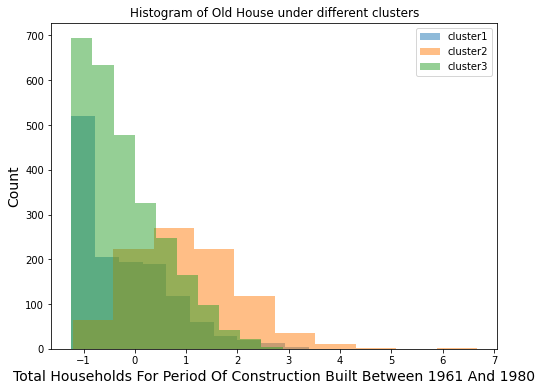

In [45]:
# visual old house
df_viz = df_kmeans.copy()
old = df_viz[['Total Households For Period Of Construction Built Between 1961 And 1980']].values
old = preprocessing.scale(old)
df_viz['Total Households For Period Of Construction Built Between 1961 And 1980'] = old

plt.figure(figsize=(8,6))
plt.hist(df_viz[df_viz['Cluster']==0]['Total Households For Period Of Construction Built Between 1961 And 1980'], alpha=0.5, label="cluster1")
plt.hist(df_viz[df_viz['Cluster']==1]['Total Households For Period Of Construction Built Between 1961 And 1980'], alpha=0.5, label="cluster2")
plt.hist(df_viz[df_viz['Cluster']==2]['Total Households For Period Of Construction Built Between 1961 And 1980'], alpha=0.5, label="cluster3")
plt.xlabel("Total Households For Period Of Construction Built Between 1961 And 1980", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of Old House under different clusters")
plt.legend(loc='upper right')

In [46]:
c1 = df_kmeans[df_kmeans['Cluster']==0]
c1['Total Households For Period Of Construction Built Between 1961 And 1980'].describe()

count    1346.000000
mean      444.293462
std       414.423815
min         0.000000
25%        59.250000
50%       354.500000
75%       721.500000
max      2073.000000
Name: Total Households For Period Of Construction Built Between 1961 And 1980, dtype: float64

In [47]:
c2 = df_kmeans[df_kmeans['Cluster']==1]
c2['Total Households For Period Of Construction Built Between 1961 And 1980'].describe()

count     949.000000
mean      996.787144
std       461.545643
min        11.000000
25%       651.000000
50%       972.000000
75%      1278.000000
max      3547.000000
Name: Total Households For Period Of Construction Built Between 1961 And 1980, dtype: float64

In [48]:
c3 = df_kmeans[df_kmeans['Cluster']==2]
c3['Total Households For Period Of Construction Built Between 1961 And 1980'].describe()

count    2705.000000
mean      455.903512
std       356.449698
min         0.000000
25%       177.000000
50%       379.000000
75%       679.000000
max      1846.000000
Name: Total Households For Period Of Construction Built Between 1961 And 1980, dtype: float64

Text(0, 0.5, 'Median Household Income (Current Year $)')

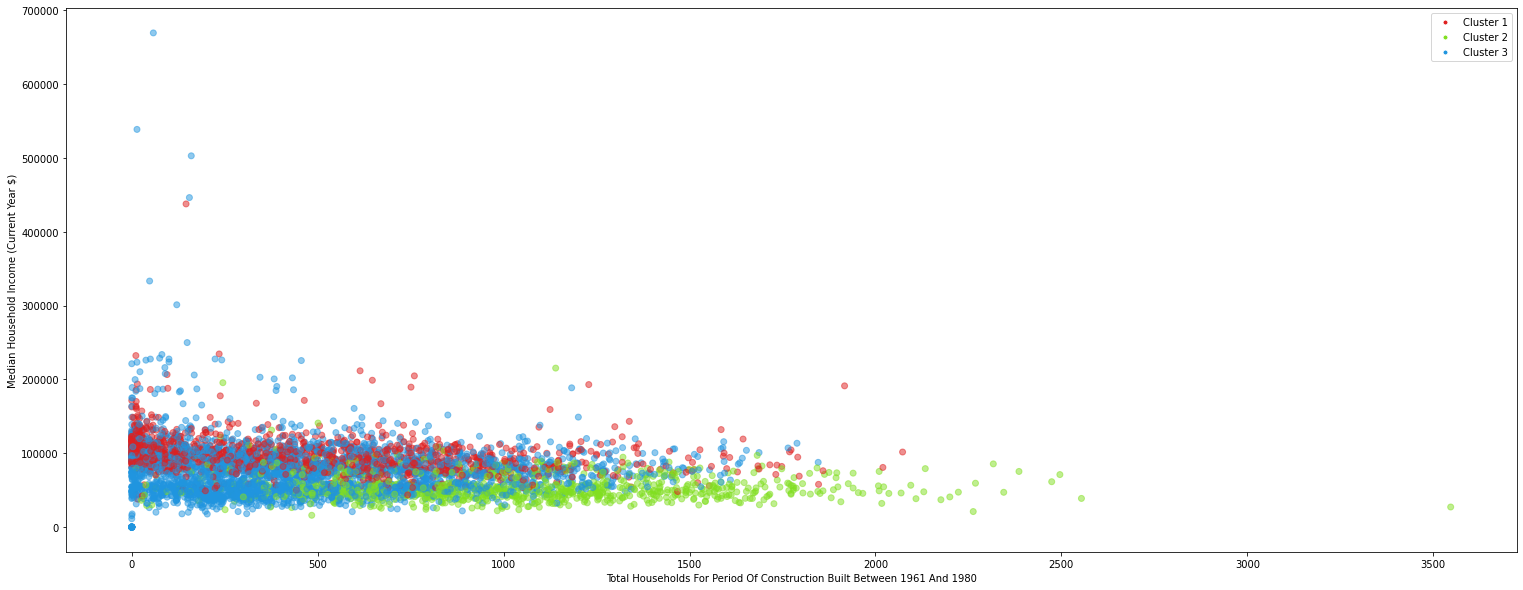

In [49]:
# cluster visual
from matplotlib.lines import Line2D
plt.figure(figsize=(26, 10))
# create color
df_viz = df_kmeans.copy()
colors = ['#DF2020', '#81DF20', '#2095DF']
df_viz['c'] = df_viz.Cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})
# visual Total Households For Structure Type Houses
plt.scatter(df_kmeans['Total Households For Period Of Construction Built Between 1961 And 1980'],df_kmeans['Median Household Income (Current Year $)'],c=df_viz.c,alpha=0.5)

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlabel('Total Households For Period Of Construction Built Between 1961 And 1980')
plt.ylabel('Median Household Income (Current Year $)')

## BIRCH and Interpretation

In [50]:
#Finding the optimal number of clusters for k-means using cross validation
#initialize for loop to calculate silhouette_score for each #cluster
k_values = np.array([2,3,4,5,6,7,9,10])
silhouette_score_values=list()
for i in k_values:
    classifier=Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=int(i), threshold=0.05)
    classifier.fit(X_scaled)
    labels= classifier.predict(X_scaled)
    print ('Number Of Clusters: '+ str(i))
 #   print (i)
    print ('Silhouette score value '+str(silhouette_score(X_scaled,labels ,metric='euclidean', sample_size=None, random_state=None)))
    silhouette_score_values.append(silhouette_score(X_scaled,labels,metric='euclidean', sample_size=None, random_state=None))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


Number Of Clusters: 2
Silhouette score value 0.19687565136772464


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


Number Of Clusters: 3
Silhouette score value 0.17275196607025772


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


Number Of Clusters: 4
Silhouette score value 0.17279438063987262


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


Number Of Clusters: 5
Silhouette score value 0.14286455384419638


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


Number Of Clusters: 6
Silhouette score value 0.15844847310813767


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


Number Of Clusters: 7
Silhouette score value 0.16580415259235604


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


Number Of Clusters: 9
Silhouette score value 0.1351699429000371


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


Number Of Clusters: 10
Silhouette score value 0.1419153880989927


In [128]:
birchmodel = Birch(n_clusters = 3, threshold=0.05)
birchmodel.fit(X_scaled)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but Birch was fitted with feature names
  "X does not have valid feature names, but"


Birch(threshold=0.05)

In [129]:
arr_b = birchmodel.predict(X_scaled).reshape(-1,1)
arr=arr_b

In [130]:
np.hstack((X_scaled,arr))

array([[-0.32748832, -0.49940416, -0.15235227, ..., -0.16217567,
         0.1304111 ,  1.        ],
       [-1.01861261, -0.9251701 ,  1.29655187, ..., -0.70501878,
        -0.20072041,  0.        ],
       [ 0.16416514,  0.14693932, -0.9199836 , ...,  0.44098334,
         0.00917891,  1.        ],
       ...,
       [-0.07142717, -0.03362648, -0.53376909, ...,  0.12217072,
        -0.04763144,  0.        ],
       [-0.47919853, -0.9128588 ,  0.37779312, ...,  0.24280252,
         0.6755064 ,  0.        ],
       [ 0.45875586, -0.10031271, -0.90079282, ...,  0.22556941,
         0.40186305,  1.        ]])

In [131]:
col_name = data.drop(columns=['Median Household Income (Current Year $)']).columns.tolist().copy()
col_name.append('Cluster')
cluster_center = pd.DataFrame(data=np.hstack((X_scaled,arr)), columns=col_name)

In [134]:
cluster_center.groupby('Cluster').mean()

,Total Population,Total Households,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Total Households Not for Tenure,Average Household Size
Cluster,,,,,,,,,,,,,,
0.0,-0.682453,-0.732128,-0.167453,-0.316790,-0.481834,-0.439528,-0.345339,-0.304221,-0.518150,-0.078607,-0.468895,-0.552398,-0.456859,0.040752
1.0,0.731873,0.490881,-0.531942,0.024879,0.608424,0.661564,0.551042,0.826168,-0.228567,0.178708,0.825148,-0.241051,0.310333,0.124538
2.0,0.124220,0.525769,0.979550,0.477629,-0.034609,-0.173709,-0.178163,-0.611445,1.140379,-0.111620,-0.344553,1.212254,0.322732,-0.231828


Cluster1 in Birch can be matched to average, Cluster2 is rich and Cluster3 is poor.

In [135]:
col_name = data.columns.tolist().copy()
col_name.append('Cluster')
col_name
stacked = np.hstack((df.values,arr))
df_birch = pd.DataFrame(data=stacked, columns=col_name)
df_birch

,Total Population,Total Households,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Total Households Not for Tenure,Average Household Size,Median Household Income (Current Year $),Cluster
0,4051.0,1441.0,323.0,199.0,53.0,182.0,526.0,911.0,525.0,5.0,919.0,424.0,98.0,3.016381,68242.12,1.0
1,2329.0,1026.0,927.0,70.0,15.0,3.0,0.0,792.0,230.0,4.0,778.0,213.0,35.0,2.350151,88172.37,0.0
2,5276.0,2071.0,3.0,607.0,567.0,651.0,106.0,1418.0,652.0,1.0,1522.0,381.0,168.0,2.772465,103853.38,1.0
3,5967.0,2203.0,133.0,1695.0,248.0,79.0,0.0,1397.0,806.0,0.0,1272.0,807.0,124.0,2.870130,82796.63,1.0
4,4236.0,1419.0,0.0,7.0,127.0,938.0,143.0,914.0,505.0,0.0,1186.0,162.0,71.0,3.142433,91648.22,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2588.0,953.0,0.0,3.0,31.0,501.0,276.0,926.0,27.0,0.0,847.0,28.0,78.0,2.957714,108823.38,1.0
4996,9036.0,3859.0,678.0,986.0,386.0,359.0,448.0,2388.0,1436.0,35.0,2602.0,1047.0,210.0,2.476295,68735.64,1.0
4997,4689.0,1895.0,164.0,485.0,511.0,523.0,29.0,677.0,1038.0,180.0,1219.0,545.0,131.0,2.658163,71370.58,0.0
4998,3673.0,1038.0,544.0,185.0,40.0,95.0,13.0,796.0,242.0,0.0,546.0,347.0,145.0,4.113102,58258.26,0.0


In [136]:
df_birch['Cluster'].value_counts()

0.0    2043
1.0    1690
2.0    1267
Name: Cluster, dtype: int64

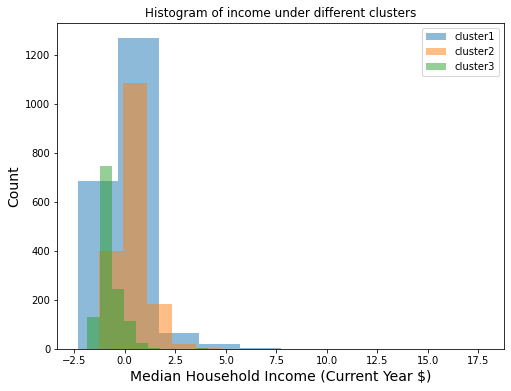

In [137]:
# visual income
df_viz = df_birch.copy()
income = df_viz[['Median Household Income (Current Year $)']].values
income = preprocessing.scale(income)
df_viz['Median Household Income (Current Year $)'] = income

plt.figure(figsize=(8,6))
plt.hist(df_viz[df_viz['Cluster']==0]['Median Household Income (Current Year $)'], alpha=0.5, label="cluster1")
plt.hist(df_viz[df_viz['Cluster']==1]['Median Household Income (Current Year $)'], alpha=0.5, label="cluster2")
plt.hist(df_viz[df_viz['Cluster']==2]['Median Household Income (Current Year $)'], alpha=0.5, label="cluster3")
plt.xlabel("Median Household Income (Current Year $)", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram of income under different clusters")
plt.legend(loc='upper right')

In [138]:
c1 = df_birch[df_birch['Cluster']==0]
c1['Median Household Income (Current Year $)'].describe()

count      2043.000000
mean      81010.939765
std       38423.111577
min           0.000000
25%       57571.820000
50%       78926.290000
75%       96368.635000
max      669559.560000
Name: Median Household Income (Current Year $), dtype: float64

In [139]:
c2 = df_birch[df_birch['Cluster']==1]
c2['Median Household Income (Current Year $)'].describe()

count      1690.000000
mean      90747.321509
std       25070.989007
min       34314.440000
25%       75426.305000
50%       89657.830000
75%      104853.135000
max      437853.930000
Name: Median Household Income (Current Year $), dtype: float64

In [140]:
c3 = df_birch[df_birch['Cluster']==2]
c3['Median Household Income (Current Year $)'].describe()

count      1267.000000
mean      53146.830616
std       18171.357449
min       16000.930000
25%       42089.620000
50%       48891.220000
75%       59103.850000
max      215418.630000
Name: Median Household Income (Current Year $), dtype: float64

## BIRCH and K-means Comaprison

In [141]:
np.array(arr_k.T[0].tolist()).shape

(5000,)

In [142]:
arr_b.T[0].shape

(5000,)

In [143]:
crosstab = pd.crosstab(np.array(arr_k.T[0].tolist()), arr_b.T[0])
crosstab

col_0,0,1,2
row_0,,,
0,158,1152,36
1,0,196,753
2,1885,342,478


[Text(33.0, 0.5, 'k-means'), Text(0.5, 15.0, 'birch')]

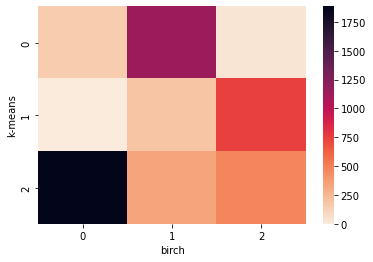

In [144]:
cmap = sns.cm.rocket_r
ax = sns.heatmap(crosstab, cmap = cmap)
ax.set(xlabel="birch", ylabel = "k-means")

In [66]:
from scipy import stats
stats.chi2_contingency(crosstab)

(4119.943925439557, 0.0, 4, array([[ 549.9756,  454.948 ,  341.0764],
        [ 387.7614,  320.762 ,  240.4766],
        [1105.263 ,  914.29  ,  685.447 ]]))

# Modeling

In [202]:
scalary = StandardScaler().fit(df['Median Household Income (Current Year $)'].values.reshape(-1,1))
scalar = StandardScaler().fit(df)
df_model = scalar.transform(df)
col_name = df.columns.tolist().copy()
col_name.append('Cluster')
stacked = np.hstack((df_model,arr_k))
df_model = pd.DataFrame(data=stacked, columns=col_name)
kX = df_model.drop(columns=['Median Household Income (Current Year $)', 'Cluster']).values
ky = df_model['Median Household Income (Current Year $)'].values

In [203]:
#split on cluster
k1X = df_model[df_model['Cluster'] == 0].drop(columns=['Median Household Income (Current Year $)', 'Cluster']).values
k1y = df_model[df_model['Cluster'] == 0]['Median Household Income (Current Year $)'].values
k2X = df_model[df_model['Cluster'] == 1].drop(columns=['Median Household Income (Current Year $)', 'Cluster']).values
k2y = df_model[df_model['Cluster'] == 1]['Median Household Income (Current Year $)'].values
k3X = df_model[df_model['Cluster'] == 2].drop(columns=['Median Household Income (Current Year $)', 'Cluster']).values
k3y = df_model[df_model['Cluster'] == 2]['Median Household Income (Current Year $)'].values

In [ ]:
'''
# create variables for the normalized data of each cluster from both model types
data1 = pd.concat([X_scaled,y_scaled], axis = 1)
#data2 = pd.concat([X_scaled,y_scaled], axis = 1)
data1=data1[[c for c in data1 if c not in ['Median Household Income (Current Year $)']] + ['Median Household Income (Current Year $)']]
data1['Cluster'] = arr_k
#data2['cluster'] = arr_b
k_1 = data1[data1['Cluster']==0]
k_2 = data1[data1['Cluster']==1]
k_3 = data1[data1['Cluster']==2]
'''

"\n# create variables for the normalized data of each cluster from both model types\ndata1 = pd.concat([X_scaled,y_scaled], axis = 1)\n#data2 = pd.concat([X_scaled,y_scaled], axis = 1)\ndata1=data1[[c for c in data1 if c not in ['Median Household Income (Current Year $)']] + ['Median Household Income (Current Year $)']]\ndata1['Cluster'] = arr_k\n#data2['cluster'] = arr_b\nk_1 = data1[data1['Cluster']==0]\nk_2 = data1[data1['Cluster']==1]\nk_3 = data1[data1['Cluster']==2]\n"

In [ ]:
#k_1_X_train, k_1_X_test, k_1_y_train, k_1_y_test = train_test_split(k_1.iloc[:,0:-2], k_1.iloc[:,-2:-1], test_size=0.25, random_state=0)

In [ ]:
#k_2_X_train, k_2_X_test, k_2_y_train, k_2_y_test = train_test_split(k_2.iloc[:,0:-2], k_2.iloc[:,-2:-1], test_size=0.25, random_state=0)

In [ ]:
#k_3_X_train, k_3_X_test, k_3_y_train, k_3_y_test = train_test_split(k_3.iloc[:,0:-2], k_3.iloc[:,-2:-1], test_size=0.25, random_state=0)

## KNR

In [204]:
from sklearn.neighbors import KNeighborsRegressor
#try to train on entire dataset
k_values = np.arange(1,22)
param_grid = dict(n_neighbors=k_values)
kfold= KFold(n_splits = 10, shuffle = True, random_state = 47)
grid = GridSearchCV(estimator=KNeighborsRegressor(), param_grid = param_grid, scoring = 'neg_mean_absolute_error', cv=kfold)
grid_result = grid.fit(kX, ky)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.403117 using {'n_neighbors': 16}


In [205]:
#train on cluster1
k_values = np.arange(1,22)
param_grid = dict(n_neighbors=k_values)
kfold= KFold(n_splits = 10, shuffle = True, random_state = 47)
grid = GridSearchCV(estimator=KNeighborsRegressor(), param_grid = param_grid, scoring = 'neg_mean_absolute_error', cv=kfold)
grid_result = grid.fit(k1X, k1y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.405464 using {'n_neighbors': 21}


In [206]:
c1_knr = grid_result.best_estimator_

In [207]:
# train on cluster2
k_values = np.arange(1,22)
param_grid = dict(n_neighbors=k_values)
kfold= KFold(n_splits = 10, shuffle = True, random_state = 47)
grid = GridSearchCV(estimator=KNeighborsRegressor(), param_grid = param_grid, scoring = 'neg_mean_absolute_error', cv=kfold)
grid_result = grid.fit(k2X, k2y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.274945 using {'n_neighbors': 11}


In [208]:
c2_knr = grid_result.best_estimator_

In [209]:
k_values = np.arange(1,22)
param_grid = dict(n_neighbors=k_values)
kfold= KFold(n_splits = 10, shuffle = True, random_state = 47)
grid = GridSearchCV(estimator=KNeighborsRegressor(), param_grid = param_grid, scoring = 'neg_mean_absolute_error', cv=kfold)
grid_result = grid.fit(k3X, k3y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.449374 using {'n_neighbors': 16}


In [210]:
c3_knr = grid_result.best_estimator_

## CART

In [211]:
from sklearn.tree import DecisionTreeRegressor

In [212]:
# tuning parameters
param_grid = {
  'max_depth' : [10,20,30,40],
  'min_samples_split':[20,40,60,80,100],
  'min_impurity_decrease': [0,0.0005,0.001,0.005,0.01]
}

In [213]:
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=1), param_grid, cv = 5, n_jobs=-1, scoring = 'neg_mean_absolute_error')

In [214]:
#train on entire dataset
gridSearch.fit(kX,ky)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, 40],
                         'min_impurity_decrease': [0, 0.0005, 0.001, 0.005,
                                                   0.01],
                         'min_samples_split': [20, 40, 60, 80, 100]},
             scoring='neg_mean_absolute_error')

In [215]:
print('Initial score: ', gridSearch.best_score_)
print('Initial parameters: ', gridSearch.best_params_)

Initial score:  -0.4289849475236508
Initial parameters:  {'max_depth': 20, 'min_impurity_decrease': 0.0005, 'min_samples_split': 80}


In [216]:
grid_result = gridSearch.fit(k1X, k1y)

In [217]:
print('Initial score: ', grid_result.best_score_)
print('Initial parameters: ', grid_result.best_params_)

Initial score:  -0.3936600326621873
Initial parameters:  {'max_depth': 20, 'min_impurity_decrease': 0.001, 'min_samples_split': 100}


In [218]:
c1_cart = grid_result.best_estimator_

In [219]:
grid_result = gridSearch.fit(k2X,k2y)

In [220]:
print('Initial score: ', grid_result.best_score_)
print('Initial parameters: ', grid_result.best_params_)

Initial score:  -0.3004964093582054
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0.01, 'min_samples_split': 60}


In [221]:
c2_cart = grid_result.best_estimator_

In [222]:
grid_result = gridSearch.fit(k3X, k3y)
print('Initial score: ', grid_result.best_score_)
print('Initial parameters: ', grid_result.best_params_)

Initial score:  -0.47678147720186975
Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 80}


In [223]:
c3_cart = grid_result.best_estimator_

## ANN

In [224]:
from keras.models import Sequential
from keras.layers.core import Dense

In [225]:
def create_model(neurons=1,optimizer='rmsprop'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=14, kernel_initializer='uniform', activation='sigmoid')) 
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    model.compile(loss='mean_absolute_error', optimizer=optimizer)
    return model

In [226]:
#lets train entire dataset first
model = KerasRegressor(build_fn=create_model, epochs=75, batch_size=100, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [227]:
neurons = [20, 30, 40] #no. of neurons in the hidden layer
optimizers = ['rmsprop', 'adam']

In [228]:
param_grid = dict(neurons = neurons, optimizer=optimizers)

In [229]:
grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_absolute_error')

In [230]:
grid_result = grid.fit(kX, ky)

Epoch 1/75
40/40 - 1s - loss: 0.8216 - 506ms/epoch - 13ms/step
Epoch 2/75
40/40 - 0s - loss: 0.7732 - 45ms/epoch - 1ms/step
Epoch 3/75
40/40 - 0s - loss: 0.7338 - 49ms/epoch - 1ms/step
Epoch 4/75
40/40 - 0s - loss: 0.7069 - 52ms/epoch - 1ms/step
Epoch 5/75
40/40 - 0s - loss: 0.6893 - 55ms/epoch - 1ms/step
Epoch 6/75
40/40 - 0s - loss: 0.6779 - 68ms/epoch - 2ms/step
Epoch 7/75
40/40 - 0s - loss: 0.6696 - 76ms/epoch - 2ms/step
Epoch 8/75
40/40 - 0s - loss: 0.6628 - 71ms/epoch - 2ms/step
Epoch 9/75
40/40 - 0s - loss: 0.6572 - 65ms/epoch - 2ms/step
Epoch 10/75
40/40 - 0s - loss: 0.6523 - 57ms/epoch - 1ms/step
Epoch 11/75
40/40 - 0s - loss: 0.6478 - 74ms/epoch - 2ms/step
Epoch 12/75
40/40 - 0s - loss: 0.6438 - 63ms/epoch - 2ms/step
Epoch 13/75
40/40 - 0s - loss: 0.6403 - 69ms/epoch - 2ms/step
Epoch 14/75
40/40 - 0s - loss: 0.6370 - 82ms/epoch - 2ms/step
Epoch 15/75
40/40 - 0s - loss: 0.6339 - 67ms/epoch - 2ms/step
Epoch 16/75
40/40 - 0s - loss: 0.6312 - 65ms/epoch - 2ms/step
Epoch 17/75
40/

In [231]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.594368 using {'neurons': 40, 'optimizer': 'rmsprop'}


In [232]:
# cluster1
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=10, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_absolute_error')
grid_result = grid.fit(k1X, k1y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


Epoch 1/50
108/108 - 1s - loss: 0.4897 - 1s/epoch - 13ms/step
Epoch 2/50
108/108 - 0s - loss: 0.4832 - 133ms/epoch - 1ms/step
Epoch 3/50
108/108 - 0s - loss: 0.4716 - 125ms/epoch - 1ms/step
Epoch 4/50
108/108 - 0s - loss: 0.4559 - 143ms/epoch - 1ms/step
Epoch 5/50
108/108 - 0s - loss: 0.4394 - 130ms/epoch - 1ms/step
Epoch 6/50
108/108 - 0s - loss: 0.4255 - 146ms/epoch - 1ms/step
Epoch 7/50
108/108 - 0s - loss: 0.4137 - 125ms/epoch - 1ms/step
Epoch 8/50
108/108 - 0s - loss: 0.4046 - 148ms/epoch - 1ms/step
Epoch 9/50
108/108 - 0s - loss: 0.3986 - 141ms/epoch - 1ms/step
Epoch 10/50
108/108 - 0s - loss: 0.3940 - 134ms/epoch - 1ms/step
Epoch 11/50
108/108 - 0s - loss: 0.3904 - 145ms/epoch - 1ms/step
Epoch 12/50
108/108 - 0s - loss: 0.3874 - 130ms/epoch - 1ms/step
Epoch 13/50
108/108 - 0s - loss: 0.3857 - 141ms/epoch - 1ms/step
Epoch 14/50
108/108 - 0s - loss: 0.3837 - 135ms/epoch - 1ms/step
Epoch 15/50
108/108 - 0s - loss: 0.3823 - 142ms/epoch - 1ms/step
Epoch 16/50
108/108 - 0s - loss: 0.3

In [233]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.376256 using {'neurons': 40, 'optimizer': 'adam'}


In [234]:
c1_ann = grid_result.best_estimator_

In [235]:
#cluster2
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=10, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_absolute_error')
grid_result = grid.fit(k2X, k2y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


Epoch 1/50
76/76 - 1s - loss: 1.0649 - 548ms/epoch - 7ms/step
Epoch 2/50
76/76 - 0s - loss: 0.8852 - 108ms/epoch - 1ms/step
Epoch 3/50
76/76 - 0s - loss: 0.8070 - 120ms/epoch - 2ms/step
Epoch 4/50
76/76 - 0s - loss: 0.7823 - 128ms/epoch - 2ms/step
Epoch 5/50
76/76 - 0s - loss: 0.7752 - 118ms/epoch - 2ms/step
Epoch 6/50
76/76 - 0s - loss: 0.7733 - 126ms/epoch - 2ms/step
Epoch 7/50
76/76 - 0s - loss: 0.7727 - 100ms/epoch - 1ms/step
Epoch 8/50
76/76 - 0s - loss: 0.7726 - 87ms/epoch - 1ms/step
Epoch 9/50
76/76 - 0s - loss: 0.7726 - 90ms/epoch - 1ms/step
Epoch 10/50
76/76 - 0s - loss: 0.7726 - 85ms/epoch - 1ms/step
Epoch 11/50
76/76 - 0s - loss: 0.7725 - 108ms/epoch - 1ms/step
Epoch 12/50
76/76 - 0s - loss: 0.7725 - 100ms/epoch - 1ms/step
Epoch 13/50
76/76 - 0s - loss: 0.7725 - 84ms/epoch - 1ms/step
Epoch 14/50
76/76 - 0s - loss: 0.7725 - 87ms/epoch - 1ms/step
Epoch 15/50
76/76 - 0s - loss: 0.7725 - 103ms/epoch - 1ms/step
Epoch 16/50
76/76 - 0s - loss: 0.7725 - 105ms/epoch - 1ms/step
Epoch 

In [236]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.769257 using {'neurons': 40, 'optimizer': 'rmsprop'}


In [237]:
c2_ann = grid_result.best_estimator_

In [238]:
#cluster3
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=10, verbose=2)
grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring='neg_mean_absolute_error')
grid_result = grid.fit(k3X, k3y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


Epoch 1/50
217/217 - 1s - loss: 0.7778 - 702ms/epoch - 3ms/step
Epoch 2/50
217/217 - 0s - loss: 0.7133 - 272ms/epoch - 1ms/step
Epoch 3/50
217/217 - 0s - loss: 0.7011 - 247ms/epoch - 1ms/step
Epoch 4/50
217/217 - 0s - loss: 0.6906 - 251ms/epoch - 1ms/step
Epoch 5/50
217/217 - 0s - loss: 0.6819 - 271ms/epoch - 1ms/step
Epoch 6/50
217/217 - 0s - loss: 0.6751 - 274ms/epoch - 1ms/step
Epoch 7/50
217/217 - 0s - loss: 0.6701 - 252ms/epoch - 1ms/step
Epoch 8/50
217/217 - 0s - loss: 0.6662 - 258ms/epoch - 1ms/step
Epoch 9/50
217/217 - 0s - loss: 0.6629 - 263ms/epoch - 1ms/step
Epoch 10/50
217/217 - 0s - loss: 0.6601 - 264ms/epoch - 1ms/step
Epoch 11/50
217/217 - 0s - loss: 0.6580 - 259ms/epoch - 1ms/step
Epoch 12/50
217/217 - 0s - loss: 0.6560 - 246ms/epoch - 1ms/step
Epoch 13/50
217/217 - 0s - loss: 0.6544 - 271ms/epoch - 1ms/step
Epoch 14/50
217/217 - 0s - loss: 0.6529 - 278ms/epoch - 1ms/step
Epoch 15/50
217/217 - 0s - loss: 0.6519 - 247ms/epoch - 1ms/step
Epoch 16/50
217/217 - 0s - loss: 0

In [239]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.637046 using {'neurons': 40, 'optimizer': 'adam'}


In [240]:
c3_ann = grid_result.best_estimator_

In summary, cluster 2 and cluster 3 should use KNR, cluster 1 should use ANN

## Predict Test Set

In [241]:
df_test = pd.read_csv('CensusCanada2016Test.csv')

In [242]:
df_test['Total Households Not for Tenure']=df_test['Total Households']-df_test['Total Households for Tenure']
df_test['Average Household Size'] = np.where(df_test['Total Households for Tenure'] == 0, 0, df_test['Total Population']/df_test['Total Households for Tenure'])
df_test = df_test.drop(columns=['Total Households For Period Of Construction'])
df_test = df_test.drop(columns=['Total Households for Tenure'])
df_test

,Total Population,Total Households,Total Households For Period Of Construction Built Before 1961,Total Households For Period Of Construction Built Between 1961 And 1980,Total Households For Period Of Construction Built Between 1981 And 190,Total Households For Period Of Construction Built Between 1991 And 2000,Total Households For Period Of Construction Built Between 2001 And 2005,Total Households For Structure Type Houses,"Total Households For Structure Type Apartment, Building Low And High Rise",Total Households For Structure Type Other Dwelling Types,Dwellings by Tenure Owner,Dwellings by Tenure Renter,Total Households Not for Tenure,Average Household Size
0,2692,893,15,21,46,648,114,883,10,0,790,46,57,3.220096
1,3884,1511,17,839,218,27,33,1025,486,0,1207,192,112,2.776269
2,7014,2768,767,615,223,435,166,1390,1378,0,1533,1019,216,2.748433
3,9136,4577,1540,969,437,244,457,2102,2461,14,2402,1830,345,2.158790
4,3614,1167,44,94,34,115,184,1069,98,0,1042,38,87,3.346296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,199,64,0,32,14,12,0,55,0,9,32,9,4,3.316667
717,3104,1718,799,575,186,114,25,152,1561,5,291,1396,31,1.839953
718,1322,501,360,101,3,11,0,481,20,0,421,72,8,2.681542
719,4288,1379,227,553,408,91,19,1143,236,0,1201,157,21,3.157585


In [243]:
scalar_test = StandardScaler().fit(df_test)
df_test_scaled = scalar_test.transform(df_test)
df_test_scaled = pd.DataFrame(data = df_test_scaled, columns=df_test.columns)
df_test_scaled.shape

(721, 14)

In [244]:
label_test = KMeansmodel.predict(df_test_scaled)
label_test

array([2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 1,
       0, 2, 2, 2, 0, 2, 2, 2, 0, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 1,
       0, 2, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 2, 2, 0, 2, 0, 2, 2, 2, 1, 2,
       2, 2, 2, 0, 2, 0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 2, 0, 1, 2, 2, 0,
       2, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 2, 0, 2, 2, 0, 0,
       2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 0, 1, 2, 2, 1, 2, 0, 2, 0,
       2, 1, 2, 0, 1, 0, 1, 1, 1, 2, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       0, 2, 0, 0, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0,
       2, 0, 0, 2, 1, 0, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 1, 2, 1, 0,
       1, 0, 2, 1, 0, 0, 2, 2, 2, 1, 2, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 2,
       2, 2, 1, 0, 0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0,

In [245]:
re = np.empty(shape=721)
test_array = df_test_scaled.values
for i in range(721):
  df_temp = pd.DataFrame(data = [test_array[i]], columns = df_test_scaled.columns)
  if label_test[i] == 0:
    pre = c1_ann.predict(df_temp)
    pre_true = scalary.inverse_transform(pre.reshape(1,-1))
  elif label_test[i] == 1:
    pre = c2_knr.predict(df_temp)
    pre_true = scalary.inverse_transform(pre.reshape(1,-1))
  else:
    pre = c3_knr.predict(df_temp)
    pre_true = scalary.inverse_transform(pre.reshape(1,-1))
  re[i] = pre_true
re

1/1 - 0s - 48ms/epoch - 48ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 19ms/epoch - 19ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 18ms/epoch - 18ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 20ms/epoch - 20ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 18ms/epoch - 18ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 18ms/epoch - 18ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 22ms/epoch - 22ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 22ms/epoch - 22ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 18ms/epoch - 18ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 20ms/epoch - 20ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 18ms/epoch - 18ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 21ms/epoch - 21ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 20ms/epoch - 20ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 20ms/epoch - 20ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 18ms/epoch - 18ms/step
1/1 - 0s - 17ms/epoch - 17ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 19ms/epoch - 19ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 18ms/epoch - 18ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 16ms/epoch - 16ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 14ms/epoch - 14ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 20ms/epoch - 20ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 17ms/epoch - 17ms/step
1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 16ms/epoch - 16ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

1/1 - 0s - 15ms/epoch - 15ms/step
1/1 - 0s - 15ms/epoch - 15ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, bu

array([115556.605     ,  85766.09875   ,  71439.60090909,  66198.42636364,
       114628.293125  ,  85436.72090909,  78212.184375  ,  68951.65909091,
       104883.62      ,  86726.63625   , 102739.179375  ,  94866.953125  ,
       107378.6796875 ,  97079.514375  ,  92036.860625  , 107672.5       ,
        84940.71875   ,  98811.06      ,  94337.713125  ,  93733.50125   ,
        83580.525     ,  55298.84909091,  78018.4609375 ,  70252.636875  ,
        98731.19125   ,  72152.798125  ,  91328.        ,  72152.798125  ,
        94470.93      ,  85852.3375    ,  94498.84375   ,  42800.19545455,
        41684.99181818,  53499.655625  ,  78087.9175    , 106775.944375  ,
        96451.81625   , 107206.25      , 104514.2734375 ,  77415.5703125 ,
        80020.328125  , 107242.8984375 ,  90149.595625  ,  57052.07545455,
        77357.1875    , 103865.071875  ,  56509.583125  ,  52695.21875   ,
        44218.82      ,  53423.76272727,  96508.6953125 ,  66521.75875   ,
        83983.125     ,  

In [246]:
re.shape

(721,)

In [247]:
file = open("Team1predictions.txt", "w")
np.savetxt(file, re, fmt='%d')
file.close()